<a href="https://colab.research.google.com/github/Biruk-gebru/Diffusion-Model/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install if not already present
!pip install torch torchvision matplotlib tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import math
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.15MB/s]


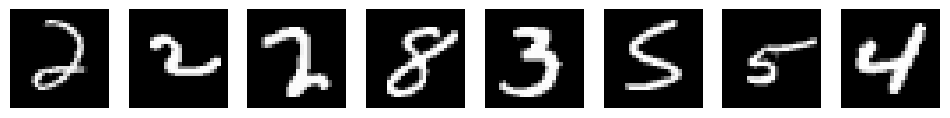

In [2]:
# Transform to [0, 1] and flatten to tensors
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1]
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Visual check
examples = next(iter(train_loader))[0][:8]
fig, axs = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axs[i].imshow(examples[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()


In [18]:
def linear_beta_schedule(timesteps, start=1e-4, end=0.02):
    return torch.linspace(start, end, timesteps)

T = 300  # Total diffusion steps (you can increase later)
betas = linear_beta_schedule(T)

alphas = 1. - betas
alpha_hats = torch.cumprod(alphas, dim=0).to(device)


In [4]:
def add_noise(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_hat = alpha_hats[t] ** 0.5
    sqrt_one_minus_alpha_hat = (1 - alpha_hats[t]) ** 0.5
    return sqrt_alpha_hat.view(-1, 1, 1, 1) * x0 + sqrt_one_minus_alpha_hat.view(-1, 1, 1, 1) * noise


In [15]:
class LabelEmbedding(nn.Module):
    def __init__(self, num_classes=10, embed_dim=28*28):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)

    def forward(self, labels):
        return self.embed(labels).view(-1, 1, 28, 28)


In [16]:
class SimpleConditionalUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, cond):
        x = torch.cat([x, cond], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleConditionalUNet().to(device)
embedding = LabelEmbedding().to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(embedding.parameters()), lr=1e-3)

epochs = 5
for epoch in range(epochs):
    for x, labels in tqdm(train_loader):
        x = x.to(device)
        labels = labels.to(device)
        t = torch.randint(0, T, (x.shape[0],), device=device).long()
        noise = torch.randn_like(x)
        x_noisy = add_noise(x, t, noise)
        cond = embedding(labels)
        pred_noise = model(x_noisy, cond)
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.0964


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.0675


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.0767


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.0574


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.0554
